In [1]:
import tensorflow as tf
import torch
import keras
from sklearn.datasets import make_circles
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#prepare the data
data_dir = './dataGrayScale/' #The information came from the Kaggle database

In [3]:
os.listdir(os.path.join(data_dir))#Operating system function to check that we linked the correct path to the data folder

['Abstract', 'realism']

In [4]:
data = tf.keras.utils.image_dataset_from_directory('dataGrayScale')#The function automatically infers the labels from the subdirectory names and loads the images accordingly

Found 18097 files belonging to 2 classes.


In [5]:
data = data.shuffle(32)

In [6]:
data_iterator = data.as_numpy_iterator()#creating an iterator from a TensorFlow dataset (data) and converting its elements to NumPy arrays

In [7]:
batch = data_iterator.next()

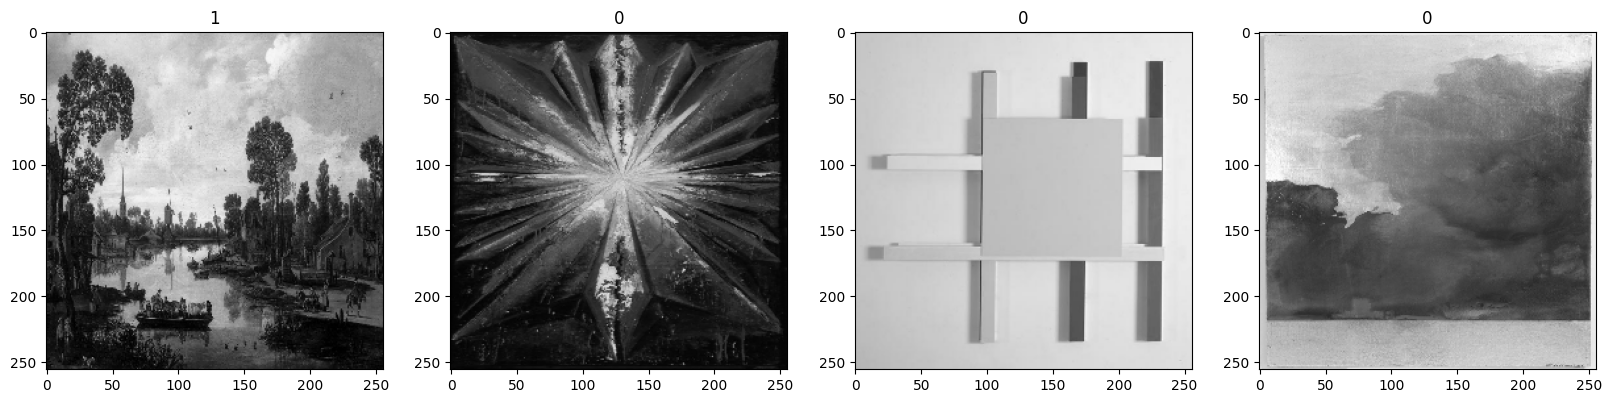

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
#x/255, y)`: This expression normalizes the image data (`x`) by dividing it by 255
#This is a common practice in image processing to scale pixel values to the range [0, 1]. The labels (`y`) are left unchanged.
data = data.map(lambda x,y: (x/255, y))

In [10]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
Confusion_Matrix_size = int(len(data)*.3)

In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)
Confusion_Matrix = data.skip(train_size+val_size).take(Confusion_Matrix_size)

In [260]:
from tensorflow.keras import layers, constraints, activations

class Layer_Dense(tf.keras.layers.Layer):
    def __init__(self, output_units, n_neurons):
        super(Layer_Dense, self).__init__()
        self.output_units = output_units
        self.n_neurons = n_neurons
        self.w = self.add_weight('weight_', shape=(n_neurons, output_units), initializer="random_normal", trainable=True)
        self.biases = self.add_weight('biases_', shape=(output_units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        output = tf.tensordot(inputs, self.w, axes=1) + self.biases
        return output
        
class Activation_ReLU:
    def __init__(self):
        super(Activation_ReLU, self).__init__()
        
        
    def call(self, inputs):
        print("Activation_ReLU",inputs)
        output = tf.maximum(tf.cast(0, tf.float32), inputs)
        return output
    def get_config(self):
        return {}

class Activation_Softmax:
    def __init__(self):
        super(Activation_Softmax, self).__init__()
        
    def forward(self, inputs):
        exp_values = tf.exp(inputs - tf.reduce_max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / tf.reduce_sum(exp_values, axis=1, keepdims=True)
        output = probabilities
        print("output",output)
        return output
        
    def get_config(self):
        return {}


In [261]:
from tensorflow.keras.layers import Layer

class CustomNNLayer(tf.keras.layers.Layer):
    def __init__(self, input_units, output_units, activation):
        super(CustomNNLayer, self).__init__()
        self.l1 = Layer_Dense(output_units, n_neurons=input_units)
        self.activation = activation
        if activation == 'relu':
            self.activation1 = Activation_ReLU()
        elif activation == 'softmax':
            self.activation1 = Activation_Softmax()

    def call(self, inputs):
        x = self.l1(inputs)
        if self.activation == 'relu':
            x = self.activation1.call(x)  # Call your custom activation function
        elif self.activation == 'softmax':
            x = self.activation1.forward(x)  # Use built-in activation function for softmax
        return x

    def get_config(self):
        config = super(CustomNNLayer, self).get_config()
        config.update({
            "input_units": self.l1.n_neurons,
            "output_units": self.l1.output_units,
            "activation": self.activation,
        })
        return config

In [264]:
import tensorflow as tf

class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        # Constructor function that initializes the CustomConv2D layer
        super(CustomConv2D, self).__init__(**kwargs)  # Call the constructor of the parent class (Layer)
        self.filters = filters  # Set the number of filters for the convolutional layer
        self.kernel_size = kernel_size  # Set the size of the kernel/filter
        
    #לבניית השכבה, כולל את הגדרת כל המשקולות הדרושים עבור השכבה  kerasמשמשת ב build פעולת 
    def build(self, input_shape):
        # Method to build the layer and create its variables
        input_channels = input_shape[-1]  # Extract the number of input channels from the input shape
        # Initialize the kernel weights with a specific shape using glorot_uniform initializer
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.kernel_size, self.kernel_size, input_channels, self.filters),
                                      initializer='glorot_uniform',
                                      trainable=True)

    def call(self, inputs):
        # Method that defines the computation performed by the layer
        kernel_height, kernel_width, _, _ = self.kernel.shape  # Get the shape of the kernel weights

        # Calculate the dimensions of the output feature maps
        out_height = inputs.shape[1] - kernel_height + 1
        out_width = inputs.shape[2] - kernel_width + 1

        # Extract image patches from the input using specified kernel size and strides
        input_patches = tf.image.extract_patches(inputs, sizes=[1, kernel_height, kernel_width, 1], strides=[1, 1, 1, 1], rates=[1, 1, 1, 1], padding='VALID')
        # Reshape the extracted patches into a format suitable for matrix multiplication
        input_patches = tf.reshape(input_patches, [-1, out_height, out_width, kernel_height * kernel_width * inputs.shape[3]])
        # Reshape the kernel weights into a 2D matrix for matrix multiplication
        kernel_flat = tf.reshape(self.kernel, [kernel_height * kernel_width * inputs.shape[3], self.filters])

        # Perform convolution by matrix multiplication between input patches and kernel weights
        outputs = tf.matmul(tf.reshape(input_patches, [-1, kernel_height * kernel_width * inputs.shape[3]]), kernel_flat)
        # Reshape the output back to the shape of feature maps
        outputs = tf.reshape(outputs, [-1, out_height, out_width, self.filters])
        return outputs

    def compute_output_shape(self, input_shape):
        # Method to compute the output shape of the layer given an input shape
        input_shape = tf.TensorShape(input_shape).as_list()  # Convert input shape to a list
        batch_size, height, width, _ = input_shape  # Extract dimensions from input shape
        out_height = height - self.kernel_size + 1  # Compute output height
        out_width = width - self.kernel_size + 1  # Compute output width
        return tf.TensorShape([batch_size, out_height, out_width, self.filters])  # Return the output shape




In [265]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  MaxPooling2D, Dense, Flatten, Dropout
import pandas as pd


input_size = (256, 256)
model = Sequential()

model.add(CustomConv2D(filters=16, kernel_size=3, input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(CustomConv2D(filters=32, kernel_size=3))
model.add(MaxPooling2D())
model.add(CustomConv2D(filters=16, kernel_size=3))
model.add(MaxPooling2D())
model.add(Flatten())

model.add(CustomNNLayer(input_units=14400,output_units=256, activation='relu'))
model.add(CustomNNLayer(input_units=256,output_units=128, activation='relu'))
model.add(CustomNNLayer(input_units=128,output_units=64, activation= 'relu'))
model.add(CustomNNLayer(input_units=64,output_units=2, activation= None))



Activation_ReLU Tensor("custom_nn_layer_52/layer__dense_52/add:0", shape=(None, 256), dtype=float32)
Activation_ReLU Tensor("custom_nn_layer_53/layer__dense_53/add:0", shape=(None, 128), dtype=float32)
Activation_ReLU Tensor("custom_nn_layer_54/layer__dense_54/add:0", shape=(None, 64), dtype=float32)


In [266]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [267]:
model.summary()

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d_35 (CustomCon  (None, 254, 254, 16)     432       
 v2D)                                                            
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 custom_conv2d_36 (CustomCon  (None, 125, 125, 32)     4608      
 v2D)                                                            
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 custom_conv2d_37 (CustomCon  (None, 60, 60, 16)     

In [167]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [168]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Layer CustomConv2D has arguments ['filters', 'kernel_size']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Layer CustomConv2D has arguments ['filters', 'kernel_size']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/20
Activation_ReLU Tensor("sequential_61/custom_nn_layer_44/layer__dense_44/add:0", shape=(None, 256), dtype=float32)
Activation_ReLU Tensor("sequential_61/custom_nn_layer_45/layer__dense_45/add:0", shape=(None, 128), dtype=float32)
Activation_ReLU Tensor("sequential_61/custom_nn_layer_46/layer__dense_46/add:0", shape=(None, 64), dtype=float32)
Activation_ReLU Tensor("sequential_61/custom_nn_layer_44/layer__dense_44/add:0", shape=(None, 256), dtype=float32)
Activation_ReLU Tensor("sequential_61/custom_nn_layer_45/layer__dense_45/add:0", shape=(None, 128), dtype=float32)
Activation_ReLU Tensor("sequential_61/custom_nn_layer_46/layer__dense_46/add:0", shape=(None, 64), dtype=float32)
396/396 [==============================] - ETA: 0s - loss: 0.4647 - accuracy: 0.7851Activation_ReLU Tensor("sequential_61/custom_nn_layer_44/layer__dense_44/add:0", shape=(None, 256), dtype=float32)
Activation_ReLU Tensor("sequential_61/custom_nn_layer_45/layer__dense_45/add:0", shape=(None, 128), dt

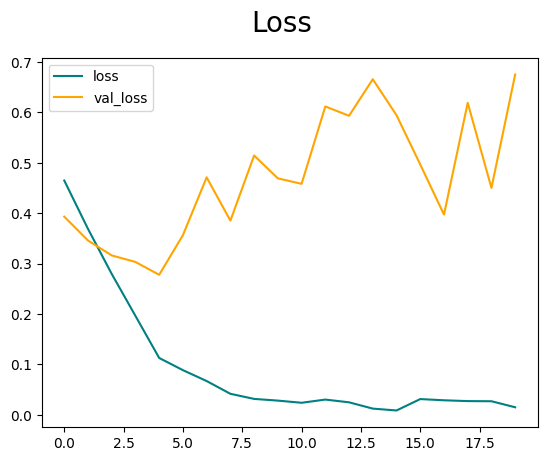

In [169]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

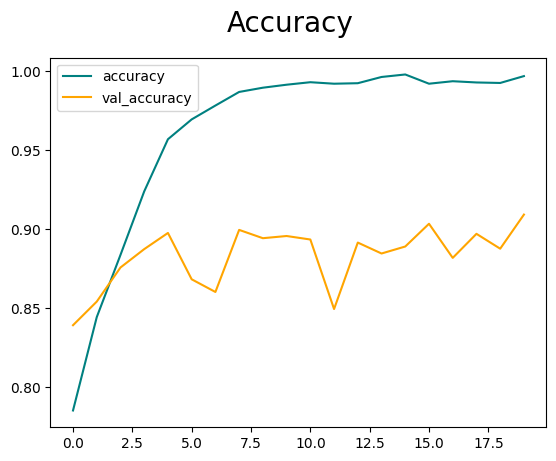

In [170]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [254]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [258]:
'''
for batch in test.as_numpy_iterator(): 
    X, y = batch
    predicted = model.predict(X)
    Softmax = Activation_Softmax()
    yhat = Softmax.forward(predicted[0])
    pre.update_state(y, yhat[0][1].numpy())
    re.update_state(y, yhat[0][1].numpy())
    acc.update_state(y, yhat[0][1].numpy())
'''


for batch in test.as_numpy_iterator(): 
    X, y = batch
    predicted = model.predict(X)
    Softmax = Activation_Softmax()
    yhat = Softmax.forward(predicted)
    pre.update_state(y, yhat[:, 1].numpy())
    re.update_state(y, yhat[:, 1].numpy())
    acc.update_state(y, yhat[:, 1].numpy())

1/1 [==============================] - 1s 1s/step
output tf.Tensor(
[[8.5100603e-01 1.4899400e-01]
 [1.0000000e+00 2.7881358e-08]
 [9.9840671e-01 1.5933532e-03]
 [1.3047362e-11 1.0000000e+00]
 [5.4179047e-05 9.9994576e-01]
 [9.9703455e-01 2.9654754e-03]
 [2.9625764e-06 9.9999702e-01]
 [1.8211756e-10 1.0000000e+00]
 [1.0000000e+00 4.5559531e-13]
 [1.0000000e+00 6.0653159e-13]
 [9.8413265e-01 1.5867313e-02]
 [9.9955434e-01 4.4568954e-04]
 [1.0000000e+00 0.0000000e+00]
 [3.9433595e-02 9.6056640e-01]
 [5.0631352e-16 1.0000000e+00]
 [1.8133113e-06 9.9999821e-01]
 [6.2812062e-16 1.0000000e+00]
 [2.1141013e-05 9.9997890e-01]
 [6.3702148e-11 1.0000000e+00]
 [1.4300264e-07 9.9999988e-01]
 [1.0000000e+00 2.4364923e-09]
 [5.8234866e-09 1.0000000e+00]
 [9.8074913e-01 1.9250894e-02]
 [9.9998879e-01 1.1165573e-05]
 [1.0000000e+00 4.2083258e-08]
 [1.4056872e-08 1.0000000e+00]
 [3.7199337e-05 9.9996281e-01]
 [3.7412819e-06 9.9999630e-01]
 [9.9906176e-01 9.3829038e-04]
 [8.0729666e-04 9.9919266e-01]
 [

In [259]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.84205127, shape=(), dtype=float32) tf.Tensor(0.89824945, shape=(), dtype=float32) tf.Tensor(0.8610017, shape=(), dtype=float32)


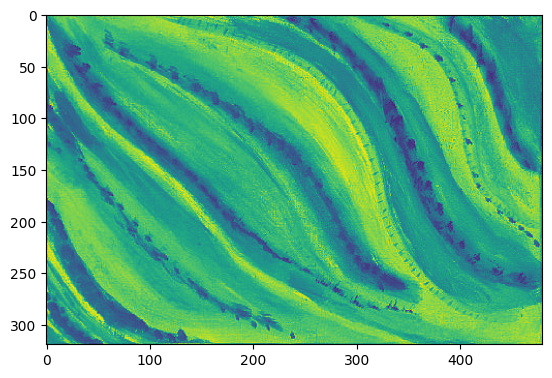

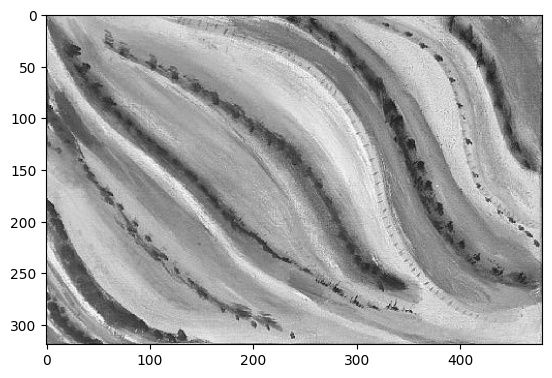

In [247]:
img = cv2.imread("C:\\Users\\user\\Desktop\\0c74daac59c1ec22e822389e206bf2b6_grayscale.jpg", cv2.IMREAD_GRAYSCALE)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()
plt.imshow(img_gray)
plt.show()

In [248]:
resize = tf.image.resize(img_gray, (256,256))

In [249]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [250]:
predicted = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 56ms/step


In [251]:
predicted

array([[ 3.5735517, -5.174816 ]], dtype=float32)

In [252]:
Softmax = Activation_Softmax()
newImg = Softmax.forward(predicted)

output tf.Tensor([[9.9984133e-01 1.5869508e-04]], shape=(1, 2), dtype=float32)


In [253]:
if newImg[0][1] > 0.5: 
    print(f'Predicted class is Rializem')
else:
    print(f'Predicted class is Abstract')

Predicted class is Abstract


In [277]:
def find_TP(y, y_hat):
    # Count the number of true positives (y = 1, y_hat = 1)
    if((y == 1) & (y_hat > 0.5)):
        return 1
    else:
        return 0

def find_FN(y, y_hat):
    # Count the number of false negatives (y = 1, y_hat = 0)
    if((y == 1) & (y_hat <0.5)):
        return 1
    else:
        return 0

def find_FP(y, y_hat):
    # Count the number of false positives (y = 0, y_hat = 1)
    if((y == 0) & (y_hat >0.5)):
        return 1
    else:
        return 0

def find_TN(y, y_hat):
    # Count the number of true negatives (y = 0, y_hat = 0)
    if((y == 0) & (y_hat <0.5)):
        return 1
    else:
        return 0

TP =0
FN =0
FP =0
TN =0
cuont =1
for batch in Confusion_Matrix.as_numpy_iterator():
    
    X, y = batch
    print("running num = ", cuont)
    print("Batch X shape:", X.shape)
    print("Batch y shape:", y.shape)
    cuont = cuont +1
    
    for i in range(len(y)):
        print(f"\nProcessing example {i+1}/{len(y)}:")
        
        predicted = loaded_model.predict(X[i:i+1])  # Assuming model.predict expects a batch input
        Softmax = Activation_Softmax()
        yhat = Softmax.forward(predicted)
        #yhat = tf.nn.softmax(newImg[0])
        print("True label:", y[i])
        print(f'y[i] = {y[i]}')
        print(f'yhat[i] = {yhat[0][1]}')  # Assuming yhat is a single prediction
        
        TP = find_TP(y[i], yhat[0][1]) + TP
        FN = find_FN(y[i], yhat[0][1]) + FN
        FP = find_FP(y[i], yhat[0][1]) + FP
        TN = find_TN(y[i], yhat[0][1]) + TN


print("\nFinal Results:")

print('TP:', TP)
print('FN:', FN)
print('FP:', FP)
print('TN:', TN)
precision = TP / (TP + FP)
print('Precision:', precision)


running num =  1
Batch X shape: (32, 256, 256, 3)
Batch y shape: (32,)

Processing example 1/32:
1/1 [==============================] - 0s 455ms/step
output tf.Tensor([[1.0000000e+00 3.8855485e-10]], shape=(1, 2), dtype=float32)
True label: 0
y[i] = 0
yhat[i] = 3.885548549575901e-10

Processing example 2/32:
1/1 [==============================] - 0s 157ms/step
output tf.Tensor([[1.000000e+00 4.290678e-13]], shape=(1, 2), dtype=float32)
True label: 0
y[i] = 0
yhat[i] = 4.2906780559071045e-13

Processing example 3/32:
1/1 [==============================] - 0s 118ms/step
output tf.Tensor([[0.9983504  0.00164959]], shape=(1, 2), dtype=float32)
True label: 0
y[i] = 0
yhat[i] = 0.0016495866002514958

Processing example 4/32:
1/1 [==============================] - 0s 173ms/step
output tf.Tensor([[8.43247e-11 1.00000e+00]], shape=(1, 2), dtype=float32)
True label: 1
y[i] = 1
yhat[i] = 1.0

Processing example 5/32:
1/1 [==============================] - 0s 112ms/step
output tf.Tensor([[0.897975

In [278]:
recall = TP / (TP + FN)
print('Recall: %f' % recall)

Recall: 0.894794


In [279]:
f1_score = 2*((precision*recall)/(precision+recall))
print('F1 score: %f' % f1_score)

F1 score: 0.869336


In [180]:
import tensorflow as tf

model.save("C:\\Users\\user\\Desktop\\modelUntitled15")

Activation_ReLU Tensor("sequential_61/custom_nn_layer_44/layer__dense_44/add:0", shape=(None, 256), dtype=float32)
Activation_ReLU Tensor("sequential_61/custom_nn_layer_45/layer__dense_45/add:0", shape=(None, 128), dtype=float32)
Activation_ReLU Tensor("sequential_61/custom_nn_layer_46/layer__dense_46/add:0", shape=(None, 64), dtype=float32)
Activation_ReLU Tensor("layer__dense_44/add:0", shape=(None, 256), dtype=float32)
Activation_ReLU Tensor("layer__dense_45/add:0", shape=(None, 128), dtype=float32)
Activation_ReLU Tensor("layer__dense_46/add:0", shape=(None, 64), dtype=float32)
Activation_ReLU Tensor("custom_nn_layer_44/layer__dense_44/add:0", shape=(None, 256), dtype=float32)
Activation_ReLU Tensor("custom_nn_layer_45/layer__dense_45/add:0", shape=(None, 128), dtype=float32)
Activation_ReLU Tensor("custom_nn_layer_46/layer__dense_46/add:0", shape=(None, 64), dtype=float32)
Activation_ReLU Tensor("custom_nn_layer_44/layer__dense_44/add:0", shape=(None, 256), dtype=float32)
Activati

INFO:tensorflow:Assets written to: C:\Users\user\Desktop\modelUntitled15\assets


INFO:tensorflow:Assets written to: C:\Users\user\Desktop\modelUntitled15\assets


In [276]:
loaded_model = keras.models.load_model("C:\\Users\\user\\Desktop\\modelUntitled15")